In [ ]:
!pip install bertopic
!pip install contractions

In [ ]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

import tensorflow as tf
# from cuml.cluster import HDBSCAN
# from cuml.manifold import UMAP
# from cuml.preprocessing import normalize

from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer 
import string
import re
import nltk
from bs4 import BeautifulSoup   
import contractions,unicodedata
nltk.download('all')
from nltk.util import bigrams
from nltk.book import FreqDist
# nltk.download('stopwords')                              # Download Stopwords.
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.


import spacy
from sklearn.cluster import KMeans
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/Data/"
data = pd.read_csv(data_path+"Data_clean_processed_sample.csv")

In [ ]:
np.random.seed(10)

In [ ]:
# data.head()

,email_id,subject,email,bow,embeddings
0,saibi-e\inbox\612#1,WSCC (Mahave 02) (San Juan 03),"Dear Power Outage Database Customer,\n\nAttach...",dear power outage database customer attached f...,"dear power outage database customer, attached ..."
1,kitchen-l\_americas\netco_restart\28#2,RE:,Ryan is waffling. I talked to him this weeken...,ryan waffling talked weekend said wife want mo...,ryan waffling. talked weekend said wife want m...
2,motley-m\sent_items\1#1,SSARR Update Available Now,"<center><LI><a Href=""http://www.nwrfc.noaa.gov...",columbia river basin lower snake updated mar,columbia river basin lower snake.....updated: mar
3,kaminski-v\all_documents\577#1,Credit Risk Model Comments - at this point.,"Hi everyone,\n\nI have run the model and, alon...",everyone run model along contract brief questi...,"everyone, run model and, along contract brief ..."
4,quigley-d\sent_items\480#1,Confirmation: Risk Management Simulation Mee...,"Hi Dutch, This message is to confirm ou...",dutch message confirm meeting thursday novembe...,"dutch, message confirm meeting on, thursday, n..."


In [ ]:
if type(data['embeddings']) is list:
    text = data['embeddings']
else:
    text = data['embeddings'].tolist()

text=[str(x) for x in text]

In [ ]:
# # %%time
# with tf.device('GPU'):
#     # embedding
#     sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
#     #sentence_model = SentenceTransformer('all-MiniLM-L12-v2')
#     embeddings = sentence_model.encode(text, show_progress_bar=True)

# all_embeddings = np.array(embeddings)
# # np.save('embeddings_L6-v2.npy', all_embeddings)
# # embeddings= np.load('embeddings_L6-v2.npy')
# #embeddings= np.load('embeddings.npy')

In [ ]:
# np.save("/content/drive/MyDrive/Capstone/embeddings_L6-v2_all.npy", all_embeddings)
embeddings= np.load("/content/drive/MyDrive/Capstone/embeddings_L6-v2.npy")

# Model

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
def create_model(topwords,n_gram, nn, min_cluster):
    from nltk.corpus import stopwords
    stop_w = stopwords.words('english')
#     stop_w = stop_w+['imagemasker','urlmasker','tofrom','namemasker','im','smith','john','pm']
    stop_w = stop_w+['tofrom','namemasker','im','smith','john','pm']
    
    # ngrams
    vectorizer_model = CountVectorizer(ngram_range=n_gram, stop_words=stop_w)
    
    # UMAP: dimensionality reduction
    umap_model = UMAP(n_neighbors=nn, min_dist=0.0, metric='cosine', random_state=42)
    
    # HDBSCAN: clustering
    hdbscan_model = HDBSCAN(min_cluster_size=min_cluster, metric='euclidean', 
                            cluster_selection_method='eom', prediction_data=True, min_samples=5)
    # hier_model = AgglomerativeClustering(n_clusters=min_cluster)
    # cluster_model = KMeans(n_clusters=min_cluster)
    
    # BERTopic
    model = BERTopic(
        top_n_words=topwords,
        # min_topic_size=min_cluster,
#         nr_topics=min_top,
        vectorizer_model=vectorizer_model,
        language='english', calculate_probabilities=True,
        #embedding_model=sentence_model,
        verbose=True,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
    )
    
    return model

In [ ]:
model=create_model(10,(1,2),10,10)
model

In [ ]:
%%time
with tf.device('GPU'):
    topics, probs = model.fit_transform(text,embeddings)


2022-11-20 19:38:21,737 - BERTopic - Reduced dimensionality
2022-11-20 19:42:45,577 - BERTopic - Clustered reduced embeddings


CPU times: user 5min 7s, sys: 2.6 s, total: 5min 9s
Wall time: 5min 25s


In [ ]:
# save the model
# file_name='/content/drive/MyDrive/Capstone/all-MiniLM-L6-v2_10_(1,2)_10_50_all'
# model.save(file_name)
#model=BERTopic.load("_".join(aux))

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Hierarchical topic modeling

In [ ]:
from scipy.cluster import hierarchy as sch
# from bertopic import BERTopic
# topic_model = BERTopic()
# topics, probs = topic_model.fit_transform(docs)

# Hierarchical topics
linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
hierarchical_topics = model.hierarchical_topics(text, linkage_function=linkage_function)

100%|██████████| 432/432 [00:23<00:00, 18.10it/s]


### Get an email with threads

In [ ]:
data[['email','id']] = data['email_id'].str.split('#',1,expand = True)

In [ ]:
len(data['email'])

20000

In [ ]:
df = data['email'].value_counts()
df = df.reset_index()

In [ ]:
thread = data.merge(df,left_on = 'email',right_on = 'index')
thread = thread[thread['email_y']>1]
len(thread)

1706

In [ ]:
thread = thread.sort_values('email_y')

In [ ]:
# for i in threads['bow']:
#   print(i)

believe conf call andy zipper jay web tomorrow chris dennis bring alternative adding min increment attribute xml dtds duration would another one add stewart
brett glass enform technology llc enterprise transformation technology phone
maria please confirm david partial fill refers transaction attempt fully expect enron send potentially large volume via price posting interface may execute multiple transaction attempt eol product enron via transaction attempt interface individual transaction attempt could much smaller volume volume posted via price posting interface basically way understand individual transaction attempt nothing however break large price post transmit multiple smaller transaction attempt large price post volume believe agreement never hurt absolutely sure concerning something magnitude importance
chris wayne reviewed transcript conversation enron conversation several item worked offline detailed listed worked offline exhibit would like enform participate discussion enron 

In [ ]:
thread['id'] = thread['id'].map(int)

In [ ]:
# email_id = thread['index'].iloc[1650]
# threads = thread[thread['email_x'] == email_id].sort_values('id')
# result = []
# prob_origin = []
# topic_evolv = []
# topic_origin = []
# for i in range(len(threads)):
#   topic_evolv.append(str(topics[threads.index[i]]))
#   topic_origin.append(str(topics[threads.index[i]]))

                  
# print(topic_evolv)
# print(topic_origin)

### Averaged topic probabilities

In [ ]:
email_id = thread['index'].iloc[1650]
threads = thread[thread['email_x'] == email_id].sort_values('id')
result = []
prob_origin = []
topic_evolv = []
topic_origin = []
for i in range(len(threads)):
  body = threads['bow'].iloc[i].split()
  weight = min(1,1/(np.log(len(body)+1)+1)*3)
  if i==0:
    topic_evolv.append(str(np.argmax(probs[threads.index[i]])))
    topic_origin.append(str(np.argmax(probs[threads.index[i]])))
    result.append(probs[threads.index[i]])
    prob_origin.append(probs[threads.index[i]])
  else:
    result.append((weight)*result[-1]+(1-weight)*probs[threads.index[i]])
    topic_evolv.append(str(np.argmax(result[-1])))
    topic_origin.append(str(np.argmax(probs[threads.index[i]])))
    prob_origin.append(probs[threads.index[i]])
                  
print(topic_evolv)
print(topic_origin)

['40', '40', '16', '16', '29']
['40', '6', '16', '16', '29']


### Topic changes over threads

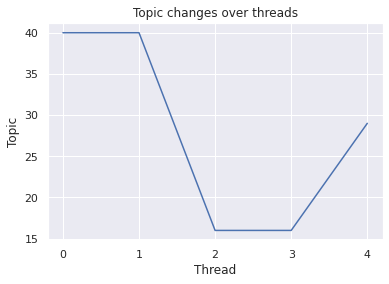

In [ ]:
x = list(range(len(topic_evolv)))
plt.plot(x,list(map(int,topic_evolv)))
plt.xticks(x)
plt.xlabel('Thread')
plt.ylabel('Topic')
plt.title('Topic changes over threads');

### Domain topic change

In [ ]:
from collections import Counter
counts = Counter(topic_evolv)
domain_topic = sorted(counts.items(),key = lambda x:x[1],reverse = True)[:2]


In [ ]:
nltk.download('all')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns. set (style= "darkgrid")

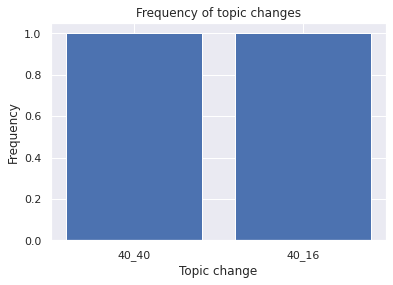

In [ ]:
freq = ['_'.join(i) for i in list(bigrams(topic_evolv))]
counts = FreqDist(freq)
# counts.plot(10)
x, y = zip (*sorted(counts.items(),key = lambda x:x[1],reverse = True)[:2])
plt.bar(x,y)
plt.title('Frequency of topic changes')
plt.ylabel('Frequency')
plt.xlabel('Topic change');

### Hierarchical result

In [ ]:
for i in range(len(hierarchical_topics['Topics'])):
  if 364 in hierarchical_topics['Topics'].iloc[i]:
    print(hierarchical_topics['Parent_ID'].iloc[i],hierarchical_topics['Parent_Name'].iloc[i],hierarchical_topics['Topics'].iloc[i])

In [ ]:
for i in range(len(hierarchical_topics['Topics'])):
  if 14 in hierarchical_topics['Topics'].iloc[i]:
    print(hierarchical_topics['Parent_ID'].iloc[i],hierarchical_topics['Parent_Name'].iloc[i],hierarchical_topics['Topics'].iloc[i])

In [ ]:
parent_id = list(hierarchical_topics[(hierarchical_topics['Child_Left_ID'].isin(topic_origin) ) | (hierarchical_topics['Child_Right_ID'].isin(topic_origin))]['Parent_ID'])
new = hierarchical_topics[hierarchical_topics['Parent_ID'].isin(parent_id)]

In [ ]:
new_topic = []
for i in range(len(new)):
  # print(i)
  new_topic+=new['Topics'].iloc[i]

In [ ]:
model.visualize_hierarchy(hierarchical_topics=hierarchical_topics,topics = map(int,list(set(topic_origin))))

In [ ]:
model.visualize_hierarchy(hierarchical_topics=hierarchical_topics,topics = map(int,list(set(topic_evolv))))

In [ ]:
tree = model.get_topic_tree(new)
print(tree)

.
├─■──sara_erik one_like erik_lisa_one answer ── Topic: 29
└─urlmasker_power_new_energy_please



In [ ]:
model.visualize_hierarchy(hierarchical_topics=hierarchical_topics,topics = list(set(new_topic)))

## Dynamic topic modeling

In [ ]:
# %%time
if type(thread['embeddings']) is list:
    text_dy = thread['embeddings']
else:
    text_dy = thread['embeddings'].tolist()

text_dy=[str(x) for x in text_dy]
# with tf.device('GPU'):
#     # embedding
#     sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
#     #sentence_model = SentenceTransformer('all-MiniLM-L12-v2')
#     embeddings_dy = sentence_model.encode(text_dy, show_progress_bar=True)

# all_embeddings_dy = np.array(embeddings_dy)
# np.save('embeddings_L6-v2.npy', all_embeddings)
# embeddings= np.load('embeddings_L6-v2.npy')
#embeddings= np.load('embeddings.npy')

In [ ]:
# np.save("/content/drive/MyDrive/Capstone/embeddings_L6-v2_dy.npy", all_embeddings_dy)
embeddings_dy= np.load("/content/drive/MyDrive/Capstone/embeddings_L6-v2_dy.npy")

In [ ]:
model_dynamic=create_model(10,(1,2),10,10)
with tf.device('GPU'):
    topics_dy, probs_dy = model_dynamic.fit_transform(text_dy,embeddings_dy)

2022-11-20 19:54:53,185 - BERTopic - Reduced dimensionality
2022-11-20 19:54:53,300 - BERTopic - Clustered reduced embeddings


In [ ]:
thread_id = [i for i in thread['id']]

In [ ]:
topics_over_time = model_dynamic.topics_over_time(text_dy,thread_id)

66it [00:05, 12.20it/s]


In [ ]:
from typing import List
import plotly.graph_objects as go
from sklearn.preprocessing import normalize
def visualize_topics_over_time(topic_model,
                               topics_over_time,
                               top_n_topics = None,
                               topics = None,
                               normalize_frequency = False,
                               width = 1250,
                               height = 450):
    """ Visualize topics over time
    Arguments:
        topic_model: A fitted BERTopic instance.
        topics_over_time: The topics you would like to be visualized with the
                          corresponding topic representation
        top_n_topics: To visualize the most frequent topics instead of all
        topics: Select which topics you would like to be visualized
        normalize_frequency: Whether to normalize each topic's frequency individually
        width: The width of the figure.
        height: The height of the figure.
    Returns:
        A plotly.graph_objects.Figure including all traces
    Usage:
    To visualize the topics over time, simply run:
    ```python
    topics_over_time = topic_model.topics_over_time(docs, topics, timestamps)
    topic_model.visualize_topics_over_time(topics_over_time)
    ```
    Or if you want to save the resulting figure:
    ```python
    fig = topic_model.visualize_topics_over_time(topics_over_time)
    fig.write_html("path/to/file.html")
    ```
    <iframe src="../../getting_started/visualization/trump.html"
    style="width:1000px; height: 680px; border: 0px;""></iframe>
    """
    colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#D55E00", "#0072B2", "#CC79A7"]
    freq_df = topic_model.get_topic_freq()
    freq_df = freq_df.loc[freq_df.Topic != -1, :]
    if topics is not None:
        selected_topics = list(topics)
    elif top_n_topics is not None:
        selected_topics = sorted(freq_df.Topic.to_list()[:top_n_topics])
    else:
        selected_topics = sorted(freq_df.Topic.to_list())

    # Prepare data
    if topic_model.custom_labels_ is not None and custom_labels:
        topic_names = {key: topic_model.custom_labels_[key + topic_model._outliers] for key, _ in topic_model.topic_labels_.items()}
    else:
        topic_names = {key: value[:40] + "..." if len(value) > 40 else value
                       for key, value in topic_model.topic_labels_.items()}
    topics_over_time["Name"] = topics_over_time.Topic.map(topic_names)
    data = topics_over_time.loc[topics_over_time.Topic.isin(selected_topics), :].sort_values(["Topic", "Timestamp"])

    # Add traces
    fig = go.Figure()
    for index, topic in enumerate(data.Topic.unique()):
        trace_data = data.loc[data.Topic == topic, :]
        topic_name = trace_data.Name.values[0]
        words = trace_data.Words.values
        if normalize_frequency:
            y = normalize(trace_data.Frequency.values.reshape(1, -1))[0]
        else:
            y = np.log(trace_data.Frequency)
        fig.add_trace(go.Scatter(x=trace_data.Timestamp, y=y,
                                 mode='lines',
                                 marker_color=colors[index % 7],
                                 hoverinfo="text",
                                 name=topic_name,
                                 hovertext=[f'<b>Topic {topic}</b><br>Words: {word}' for word in words]))

    # Styling of the visualization
    fig.update_xaxes(showgrid=True)
    fig.update_yaxes(showgrid=True)
    fig.update_layout(
        yaxis_title="Normalized Frequency" if normalize_frequency else "Log_Frequency",
        title={
            'text': "<b>Topics over Threads",
            'y': .95,
            'x': 0.40,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=22,
                color="Black")
        },
        template="simple_white",
        width=width,
        height=height,
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
        ),
        legend=dict(
            title="<b>Global Topic Representation",
        )
    )
    return fig

In [ ]:
visualize_topics_over_time(model_dynamic,topics_over_time, top_n_topics=10)

In [ ]:
# model_dynamic.visualize_topics_over_time(topics_over_time, top_n_topics=10)